# Business survival prediction

## Contents
 - Motivation
 - Problem Description
 - Import and Helper Functions
 - Reading Yelp data
 - Feature Engineering, Cleaning
 - Exploratory Data Analysis
 - Modelling
 - Performance comparison of different models

## Motivation


- Most business owners have this question "Will my business survive or not in the future years?"
- The survival of a business might depend on various factors: The locality of the business, the type of business, reviews and ratings a business gets, the type of users that use the business. 
- So, It would really be helpful to the business owners to know how likely it is for their business to survive. 
- The question one tries to answer is "**Would a business survive after the year # ?**"
- Or this solution focuses on the year 2020 as Corona started this year and would be an interesting candidate for this question and **only restaurants** are considered for this analysis. So, the new question translates as follows
- "**Would your restaurant survive after the year 2020 ?**"


## Problem Description


- First the yelp dataset given consists of multiple json files giving information about
 - user
 - review
 - checkin
 - tips
 - business
 
- The column 'is_open' in the business dataset tell if the business is open at the time of release of the dataset ie, 2022
- But this column does not give any information if the business would survive in the future.
- **How to know if a business would survive in the future based on the "is_open" column?**
    - To know if a business would survive or not, one must know the the date a business was closed.
    - This date of closing for a closed business is not explicity given in the dataset. But one can assume this to be the **year of the last review/checkin/tip.**
    
    - **When can a business be considered as survived?**
        - A business is considered survived after 2020, if the last review/checkin/tip is beyond 2020, regardless of the value of the "is_open" label.
    - **When can a business be considered as not survived?**
        - Let's say if the last review/checkin/tip of a business is in 2020 and the "is_open" label=0 (closed), then it could be assumed that the business closed in 2020.
    
 
    


## Imports and Helper Functions

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import json
import csv
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
pd.set_option("display.max_columns", 500)


In [3]:
# Plotting the confusion matrix
def confusion_matrix_plot(target_test, y_pred):
    conf_matrix = confusion_matrix(y_true=target_test, y_pred=y_pred)
    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
# function to convert a json file into a tsv file (tab-separated values file)
def json_to_tsv(input_name, output_name, columns):
    outfile = open(output_name, 'w')
    sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
    sfile.writerow(columns)
    with open(input_name, encoding="utf-8") as f:
        for line in f:
            row = json.loads(line)
            write_list = []
            # some special char must be encoded in 'utf-8'
            for i in columns:
                write_list.append(row[i])
            sfile.writerow(write_list)    
    outfile.close()

## Reading Yelp Data

**Reading JSON review file into dataframe**

In [4]:
#reading review data

input_review = 'yelp_dataset/yelp_academic_dataset_review.json'
output_review = "review_stars.tsv"
cols_review = [ 'business_id',  'date']
json_to_tsv(input_review, output_review, cols_review)
df_review = pd.read_csv(output_review, delimiter ="\t", encoding="utf-8")

**Reading JSON checkin file into dataframe**

In [5]:
#reading checkin data

input_checkin = 'yelp_dataset/yelp_academic_dataset_checkin.json'
output_checkin = "checkin.tsv"
cols_checkin = ['business_id','date']
json_to_tsv(input_checkin, output_checkin, cols_checkin)
df_checkin = pd.read_csv(output_checkin, delimiter ="\t", encoding="utf-8")


**Reading JSON tips file into dataframe**

In [6]:
#reading tips data

input_tip = 'yelp_dataset/yelp_academic_dataset_tip.json'
output_tip = "tip.tsv"
cols_tip = ['date','business_id']
json_to_tsv(input_tip, output_tip, cols_tip)
df_tip = pd.read_csv(output_tip, delimiter ="\t", encoding="utf-8")


**Reading JSON business file into dataframe**

In [7]:
#reading business data

input_business = 'yelp_dataset/yelp_academic_dataset_business.json'
output_business = "business.tsv"
cols_business = ['business_id','name', "city",'state','postal_code','latitude','longitude',
                "stars", 'review_count', 'is_open','attributes','categories', 'hours']
json_to_tsv(input_business, output_business, cols_business)
df_business = pd.read_csv(output_business, delimiter ="\t", encoding="utf-8")


##  Feature engineering, Cleaning

**In this section:**
 - useful features are derived
 - the derived features are cleaned

The business dataset from Yelp is predominantly used with the following features derived.
 
**Features derived**
 - **Last activity of a business**
     - When did a business get its last tip/checkin/review?
 - **First activity of a business**
     - When did a business get its first tip/checkin/review?
 - **Age**
     - What is the age of the business as of 2020?
 - **Total tip**
     - The total number of tips a business has received.
 - **Total checkin**
     - The total number of checkin a business has received.    
 - **Number of similar businesses in the same state**
     - The total number of similar businesses in the same state.
  

In [8]:
#class that does feature engineering and preprocessing
class Data_preprocess:
 
    # init method or constructor
    def __init__(self):
        self.year = 2020
        self.df_tip = df_tip.copy()
        self.df_checkin = df_checkin.copy()
        self.df_review = df_review.copy()
        self.df_business = df_business.copy()
        
        ## restricting businesses to only restaurants
        self.df_business = self.df_business[self.df_business['categories'].str.contains(
              'Restaurants|Food|restaurants|food',
              case=False, na=False)]
    
    # Method to find out year of the last and first tip for a business
    def derive_last_tip_feature(self):
        self.df_tip["date"] = pd.to_datetime(self.df_tip["date"]).dt.year
        self.df_tip = self.df_tip.join(self.df_tip.groupby("business_id")["date"].max(), on='business_id', rsuffix='_last_tip')
        self.df_tip = self.df_tip.join(self.df_tip.groupby("business_id")["date"].min(), on='business_id', rsuffix='_first_tip')
        self.df_tip_temp = self.df_tip.drop_duplicates("business_id", keep="first")
        self.df_business = pd.merge(self.df_business, self.df_tip_temp[["business_id", "date_last_tip","date_first_tip"]], on="business_id", how="left")
        
    # Method to find out year of the last and first checkin for a business
    def derive_last_checkin_feature(self):
        self.df_checkin = self.df_checkin.assign(date = self.df_checkin.date
                         .str.split(', ')).explode('date')
        self.df_checkin["date"] = pd.to_datetime(self.df_checkin["date"]).dt.year
        self.df_checkin = self.df_checkin.join(self.df_checkin.groupby("business_id")["date"].max(), on="business_id", rsuffix="_last_checkin")
        self.df_checkin = self.df_checkin.join(self.df_checkin.groupby("business_id")["date"].min(), on="business_id", rsuffix="_first_checkin")
        self.df_checkin_temp = self.df_checkin.drop_duplicates("business_id", keep="first")
        self.df_business = pd.merge(self.df_business, self.df_checkin_temp[["business_id", "date_last_checkin", "date_first_checkin"]], on="business_id", how="left")
        
    # Method to find out year of the last and first review for a business
    def derive_last_review_feature(self):
        self.df_review["date"] = pd.to_datetime(self.df_review["date"]).dt.year
        self.df_review = self.df_review.join(self.df_review.groupby("business_id")["date"].max(), on='business_id', rsuffix='_last_review')
        self.df_review = self.df_review.join(self.df_review.groupby("business_id")["date"].min(), on='business_id', rsuffix='_first_review')
        self.df_temp = self.df_review.drop_duplicates("business_id", keep="first")
        self.df_business = pd.merge(self.df_business, self.df_temp[["business_id", "date_last_review", "date_first_review"]], on="business_id", how="left")
        
    # Method to find out year of the last and first activity computed using checkin, review and tip
    def derive_last_activity_feature(self):
        self.df_business["last_activity"] = self.df_business[["date_last_tip", "date_last_checkin","date_last_review"]].max(axis=1)
        self.df_business["first_activity"] = self.df_business[["date_first_tip", "date_first_checkin","date_first_review"]].min(axis=1)
        
    # Age of the business
    def derive_age_feature(self):
        self.df_business.loc[:,"age"] = 0
        self.df_business.loc[:,"age"] = self.year  - self.df_business.loc[:,"first_activity"]
        
    # Calculating the total number of tips a business has received so far
    def derive_total_tip_feature(self):
        self.df_tip = self.df_tip.loc[self.df_tip.date<=self.year]
        self.df_tip = self.df_tip.join(self.df_tip.groupby("business_id").count()["date"], on="business_id", rsuffix="_derived")
        self.df_tip = self.df_tip.rename({"date_derived":"total_tip_count"},axis="columns")
        self.df_tip_count = self.df_tip[["business_id","total_tip_count"]].drop_duplicates("business_id", keep="first")
        self.df_business = pd.merge(self.df_business, self.df_tip_count, on="business_id", how="left")
        
    # Calculating the total number of checkins a business has received so far
    def derive_total_checkin_feature(self):
        self.df_checkin = self.df_checkin.loc[self.df_checkin["date"]<=self.year]
        self.df_checkin = self.df_checkin.join(self.df_checkin.groupby("business_id").count()["date"], on="business_id", rsuffix="_derived")
        self.df_checkin = self.df_checkin.rename({"date_derived":"total_checkin_count"},axis="columns")
        self.df_checkin_count = self.df_checkin[["business_id","total_checkin_count"]].drop_duplicates("business_id", keep="first")
        self.df_business = pd.merge(self.df_business, self.df_checkin_count, on="business_id", how="left")
        
    # How many similar businesses are around one business?
    def similarity(self,x): 
        y = self.df_business.loc[(self.df_business["city"] == x["city"]) & (self.df_business["is_open"] == 1) & (self.df_business["last_activity"] >= x["last_activity"]) ]
        if(len(y)==0):
            return 0
        xcat = [x[11]]
        xcat = pd.Series(xcat)
        xcat = xcat.repeat([len(y)])
        li = []
        for a ,b in zip(xcat, y.categories):
            if((isinstance(a, str)) & (isinstance(b, str))):
                if(len(set(a) & set(b)))>1:
                    li.append(1)
                else: 
                    li.append(0)  
            else:
                return 0
        return sum(li)-1
    
    # Cleaning rows
    def clean_rows(self):
        print("Removing irrelevant rows")
        
        #Removing restaurants that were closed before 2020
        df_dead_before_year = self.df_business.loc[(self.df_business["last_activity"]<=self.year) & (self.df_business["is_open"]==0) ]
        self.df_business = self.df_business[~self.df_business.business_id.isin(df_dead_before_year.business_id)]
        
        #Considering only restaurants that were open on or before the year 2020
        self.df_business = self.df_business.loc[self.df_business["first_activity"]<=self.year]
        self.df_business.loc[self.df_business["last_activity"]>self.year,"last_activity"] = self.year
        
    # Dropping unnecessary columns and handle NULL values
    def clean_columns(self):
        
        #Dropping unnecessary columns
        drop_columns = ["business_id","name","attributes","hours","categories",
               "date_last_tip","date_first_tip","date_last_checkin","date_first_checkin",
                "date_last_review", "date_first_review"]
        self.df_business = self.df_business.drop(drop_columns, axis=1)
        
        # handle NULL values
        self.df_business.loc[self.df_business["total_tip_count"].isnull(),"total_tip_count"] = 0
        self.df_business.loc[self.df_business["total_checkin_count"].isnull(),"total_checkin_count"] = 0
        self.df_business = self.df_business.loc[self.df_business["postal_code"].notnull()]
        print(self.df_business.isnull().sum())
        

    #derive features and clean them
    def derive_clean_features(self):
        
        print("Calculating year of the last and first tip for a business")
        self.derive_last_tip_feature()
        
        print("Calculating year of the last and first checkin for a business")
        self.derive_last_checkin_feature()
        
        print("Calculating year of the last and first review for a business")
        self.derive_last_review_feature()
        
        print("Calculating year of the last and first activity computed using checkin, review and tip")
        self.derive_last_activity_feature()
        
        print("Removing irrelevant rows")
        self.clean_rows()
        
        print("Calculating age of a business")
        self.derive_age_feature()
        
        print("Calculating the total number of tips a business has received so far")
        self.derive_total_tip_feature()
        
        print("Calculating the total number of checkin a business has received so far")
        self.derive_total_checkin_feature()
        
        print("Calculating number of similar businesses")
        self.df_business["similar_restaurants"] = self.df_business.apply(lambda x: self.similarity(x), axis=1)
        
        print("Removing irrelevant columns and handle NULL values")
        self.clean_columns()
        return self.df_business



In [9]:
# creating an object for the Data_preprocess class and deriving necessary features
preprocess = Data_preprocess()
df_business = preprocess.derive_clean_features() 

Calculating year of the last and first tip for a business
Calculating year of the last and first checkin for a business
Calculating year of the last and first review for a business
Calculating year of the last and first activity computed using checkin, review and tip
Removing irrelevant rows
Removing irrelevant rows
Calculating age of a business
Calculating the total number of tips a business has received so far
Calculating the total number of checkin a business has received so far
Calculating number of similar businesses
Removing irrelevant columns and handle NULL values
city                   0
state                  0
postal_code            0
latitude               0
longitude              0
stars                  0
review_count           0
is_open                0
last_activity          0
first_activity         0
age                    0
total_tip_count        0
total_checkin_count    0
similar_restaurants    0
dtype: int64


## Exploratory Data Analysis

**What are the columns used and what are their datatypes?**

In [10]:
df_business.dtypes

city                    object
state                   object
postal_code             object
latitude               float64
longitude              float64
stars                  float64
review_count             int64
is_open                  int64
last_activity          float64
first_activity         float64
age                    float64
total_tip_count        float64
total_checkin_count    float64
similar_restaurants      int64
dtype: object

**How are the features correlated with one another?**

[Text(0.5, 1.0, 'Heat map')]

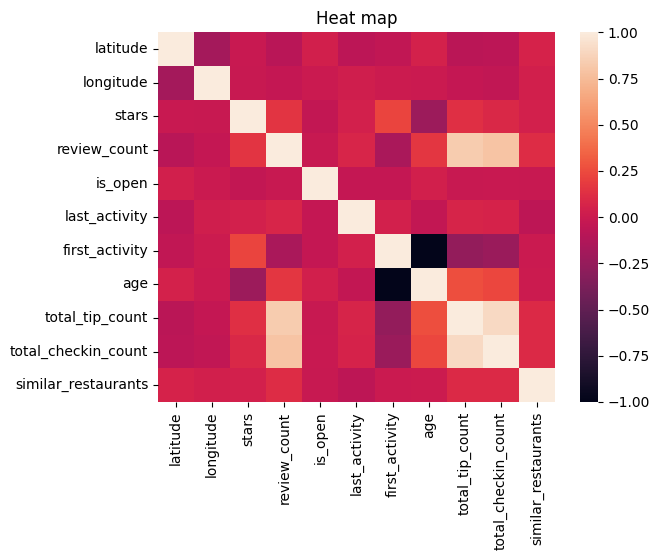

In [11]:
sns.heatmap(df_business.corr()).set(title='Heat map')

**Does age have any effect on the survival of a restaurant?**

[Text(0.5, 1.0, 'Comparison of average age of open/closed restaurants')]

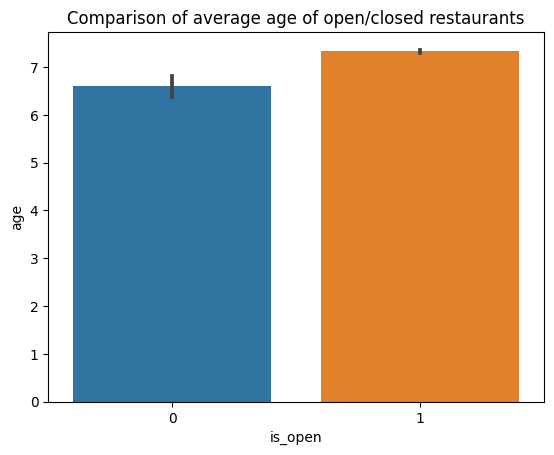

In [12]:
sns.barplot(data=df_business, x="is_open", y = "age").set(title='Comparison of average age of open/closed restaurants')

Note: Average Age of open restaurants are higher compared to closed restaurants. This is expected

**What is the distribution of stars for open and closed restaurants?**

[Text(0.5, 1.0, 'Distribution of stars for open and closed restaurants')]

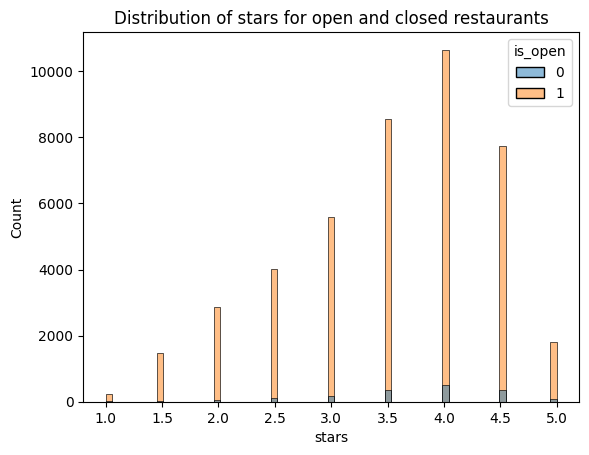

In [13]:
sns.histplot(data=df_business, x="stars", hue="is_open").set(title='Distribution of stars for open and closed restaurants')

**Does the number of similar business affect if a business would survive or not?**

Text(0.5, 1.0, 'Effect of no. similar restaurants on the survival')

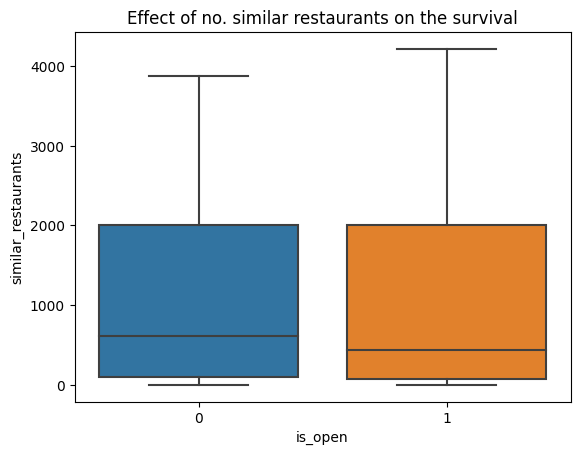

In [14]:
sns.boxplot(data=df_business, x="is_open", y="similar_restaurants").set_title("Effect of no. similar restaurants on the survival")

Note: On average, the number of similar restaurants is less for open restaurants. This could mean less competition and could enhance the probability of survival

## Modelling

This is a **binary classification** task as the target "is_open" is binary.

The following classifiers are used:
- Logisitc regression (as a baseline)
- Support Vector Classifier
- Catboost (A gradient boosted decision tree)


#### Handling categorical and numerical columns

In [15]:
cat_features = list(df_business.drop("is_open", axis=1).select_dtypes(exclude=[int, float]).columns)
num_features = list(df_business.drop("is_open", axis=1).select_dtypes(exclude=[object]).columns)

In [16]:
df_business["is_open"].value_counts()

1    42928
0     1652
Name: is_open, dtype: int64

The dataset is imbalanced with minority class being the closed restaurants
#### Balancing the imbalanced dataset by oversampling the minority class

In [17]:
oversample =RandomOverSampler(sampling_strategy ="minority")
X, y = oversample.fit_resample(df_business.drop("is_open",axis=1), df_business["is_open"])

In [18]:
df_business = pd.concat([X, y], axis=1)

In [19]:
y.value_counts()

1    42928
0    42928
Name: is_open, dtype: int64

#### Train-test split

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, cat_features),
    ('standard_scaler', numerical_preprocessor, num_features)])

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    df_business.drop("is_open",axis=1), df_business["is_open"], random_state=42)

### Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model_logistic = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
model_logistic



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'state',
                                                   'postal_code']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'stars', 'review_count',
                                                   'last_activity',
                                                   'first_activity', 'age',
                                                   'total_tip_count',
                                                   'total_checkin_count',
                                                   'similar_restaurants'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

#### Performance evaluation

In [23]:
_ = model_logistic.fit(data_train, target_train)

In [24]:
pred_test = model_logistic.predict(data_test)

In [25]:
model_logistic.score(data_test, target_test)
print(metrics.classification_report(target_test, pred_test))

              precision    recall  f1-score   support

           0       0.66      0.78      0.71     10672
           1       0.73      0.60      0.66     10792

    accuracy                           0.69     21464
   macro avg       0.69      0.69      0.69     21464
weighted avg       0.69      0.69      0.69     21464



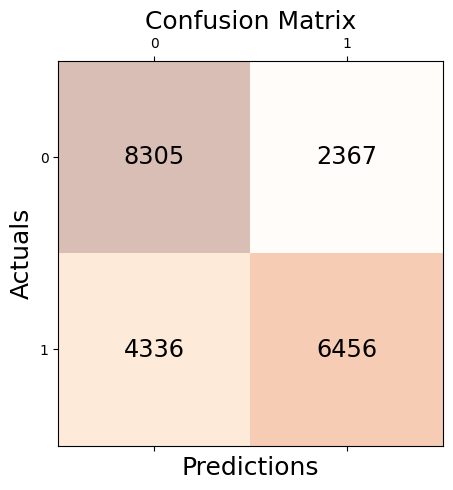

In [26]:

confusion_matrix_plot(target_test, pred_test)

### Support vector machine

In [27]:

from sklearn import svm
from sklearn.pipeline import make_pipeline

model_svc = make_pipeline(preprocessor, svm.SVC())
model_svc



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'state',
                                                   'postal_code']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'stars', 'review_count',
                                                   'last_activity',
                                                   'first_activity', 'age',
                                                   'total_tip_count',
                                                   'total_checkin_count',
                                                   'similar_restaurants'])])),
                ('svc', SVC())])

In [28]:
_ = model_svc.fit(data_train, target_train)

In [29]:
pred_test = model_svc.predict(data_test)

#### Performance evaluation

In [32]:
model_svc.score(data_test, target_test)
print(metrics.classification_report(target_test, pred_test))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82     10672
           1       0.89      0.70      0.79     10792

    accuracy                           0.81     21464
   macro avg       0.82      0.81      0.80     21464
weighted avg       0.82      0.81      0.80     21464



[[9742  930]
 [3217 7575]]


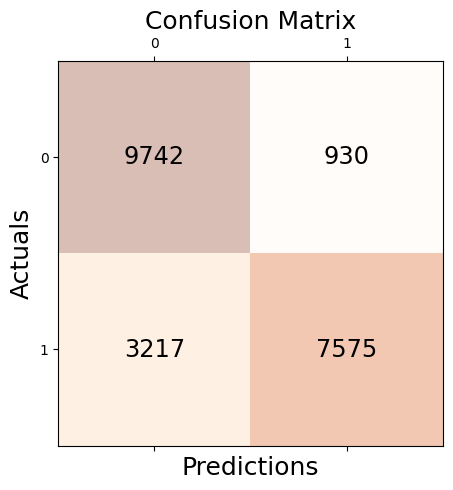

In [33]:
print(metrics.confusion_matrix(target_test, pred_test))


confusion_matrix_plot(target_test, pred_test)

### Catboost

In [48]:
train_dataset = cb.Pool(data_train, target_train, cat_features = cat_features) 
test_dataset = cb.Pool(data_test, target_test, cat_features = cat_features)

**Grid search is done to find the best parameters,
but it is commented because it takes longer time to run**

In [ ]:
"""
# Performing grid search to identify the best hyper-parameters
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)
"""

In [50]:
model = cb.CatBoostClassifier(iterations = 200, learning_rate =0.1, l2_leaf_reg=0.2,depth=8)

In [51]:
model.fit(train_dataset)

0:	learn: 0.6648089	total: 52.6ms	remaining: 10.5s
1:	learn: 0.6203822	total: 99.4ms	remaining: 9.84s
2:	learn: 0.5826186	total: 138ms	remaining: 9.07s
3:	learn: 0.5562374	total: 171ms	remaining: 8.38s
4:	learn: 0.5365531	total: 196ms	remaining: 7.65s
5:	learn: 0.5245594	total: 222ms	remaining: 7.18s
6:	learn: 0.5031353	total: 252ms	remaining: 6.94s
7:	learn: 0.4943005	total: 286ms	remaining: 6.86s
8:	learn: 0.4840355	total: 314ms	remaining: 6.66s
9:	learn: 0.4786388	total: 341ms	remaining: 6.49s
10:	learn: 0.4727496	total: 369ms	remaining: 6.34s
11:	learn: 0.4608929	total: 395ms	remaining: 6.19s
12:	learn: 0.4562764	total: 421ms	remaining: 6.06s
13:	learn: 0.4436087	total: 449ms	remaining: 5.96s
14:	learn: 0.4397862	total: 474ms	remaining: 5.85s
15:	learn: 0.4350850	total: 508ms	remaining: 5.84s
16:	learn: 0.4293009	total: 536ms	remaining: 5.77s
17:	learn: 0.4156591	total: 568ms	remaining: 5.75s
18:	learn: 0.4096878	total: 595ms	remaining: 5.67s
19:	learn: 0.4084623	total: 623ms	remai

162:	learn: 0.1647599	total: 4.66s	remaining: 1.06s
163:	learn: 0.1637540	total: 4.68s	remaining: 1.03s
164:	learn: 0.1631534	total: 4.71s	remaining: 1s
165:	learn: 0.1625957	total: 4.74s	remaining: 971ms
166:	learn: 0.1617488	total: 4.77s	remaining: 943ms
167:	learn: 0.1609780	total: 4.8s	remaining: 914ms
168:	learn: 0.1606765	total: 4.82s	remaining: 885ms
169:	learn: 0.1597445	total: 4.85s	remaining: 856ms
170:	learn: 0.1588835	total: 4.88s	remaining: 828ms
171:	learn: 0.1586513	total: 4.91s	remaining: 799ms
172:	learn: 0.1583901	total: 4.93s	remaining: 770ms
173:	learn: 0.1577401	total: 4.96s	remaining: 741ms
174:	learn: 0.1566664	total: 4.99s	remaining: 713ms
175:	learn: 0.1554982	total: 5.02s	remaining: 685ms
176:	learn: 0.1545685	total: 5.05s	remaining: 656ms
177:	learn: 0.1539265	total: 5.08s	remaining: 628ms
178:	learn: 0.1532513	total: 5.11s	remaining: 600ms
179:	learn: 0.1520587	total: 5.15s	remaining: 572ms
180:	learn: 0.1516282	total: 5.17s	remaining: 543ms
181:	learn: 0.15

In [52]:
y_pred = model.predict(data_test)

#### Performance evaluation

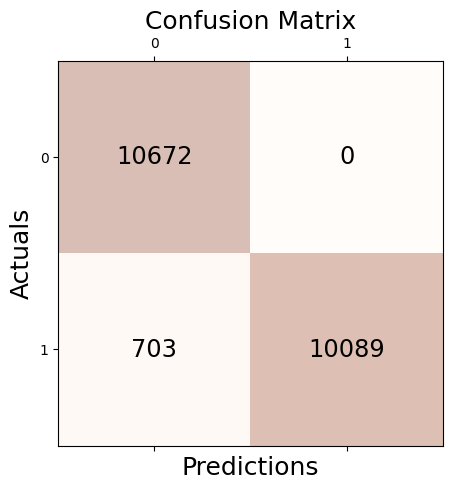

In [53]:

confusion_matrix_plot(target_test, y_pred)

In [54]:

print(metrics.classification_report(target_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10672
           1       1.00      0.93      0.97     10792

    accuracy                           0.97     21464
   macro avg       0.97      0.97      0.97     21464
weighted avg       0.97      0.97      0.97     21464



## Performance comparison of different models

| Model   | Logistic Regression (F1) | Support Vector Classifier (F1) | Catboost (F1) |
|---------|---------------------|---------------------------|----------|
| Class 0 | 0.70                | 0.82                      | **0.97**     |
| Class 1 | 0.66                | 0.78                      | **0.97**     |

**Catboost model could used to predict as it gives F1 score better than the Logisitc Regression model and the Support Vector Classifier**